# Double synchronization artifact

Notebook to check if alignment of EEG and DBS-LFP recordings is ok by verifying that both synchronization artifacts remain aligned.

Tested on:
- P4-2001 (PD patient) pre8walk block
- Epilepsy patient 2


In [1]:
import os
import numpy as np
import mne
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
from pathlib import Path
from scipy.signal import find_peaks

from dbs_eeg_sync.data_loader import load_eeg_data, open_json_file, read_time_domain_data
from dbs_eeg_sync.sync_artifact_finder import detect_dbs_sync_artifact, detect_eeg_sync_artifact
from dbs_eeg_sync.synchronizer import cut_data_at_sync, synchronize_data
from dbs_eeg_sync.plotting import apply_publication_style, EEG_COLOR, DBS_COLOR


## Load P4-2001 (PD Patient)


In [2]:
# EEG
sub_id = 'P4-2001'
block = 'pre8walk'
dataDir_server = r"/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB"

eeg_filepath = os.path.join(dataDir_server, sub_id, 'ProcessedData', 'EEG', block, block + '_prep.set')
eeg_raw_pd = mne.io.read_raw_eeglab(eeg_filepath, preload=True)

print(f"EEG: {eeg_raw_pd.n_times} samples at {eeg_raw_pd.info['sfreq']} Hz ({eeg_raw_pd.times[-1]:.2f} sec)")

EEG: 1244946 samples at 2000.0 Hz (622.47 sec)


In [3]:
# DBS
dbs_path_pd = "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2001/RawData/DBS/Report_Json_Session_Report_20240610T162159.json"
json_data_pd = open_json_file(dbs_path_pd)
dbs_data_pd = read_time_domain_data(json_data_pd, 5)
dbs_signal_pd = dbs_data_pd["TimeDomainData"].values
dbs_fs_pd = dbs_data_pd["SampleRateInHz"][0]

print(f"DBS: {len(dbs_signal_pd)} samples at {dbs_fs_pd} Hz ({len(dbs_signal_pd)/dbs_fs_pd:.2f} sec)")

DBS: 146000 samples at 250 Hz (584.00 sec)


## Load Epilepsy Patient 2


In [4]:
# # EEG
# path = r"/Volumes/green_groups_re_public/RELab/Data_confidential/StimuLOOP_Neurofeedback/eeg_dbs_sync_epi/eeg_epi_pat2_raw.fif"
# eeg_raw_epi = mne.io.read_raw_fif(path, preload=True)

# print(f"EEG: {eeg_raw_epi.n_times} samples at {eeg_raw_epi.info['sfreq']} Hz ({eeg_raw_epi.times[-1]:.2f} sec)")


In [5]:
# # DBS
# json_file = Path(r"/Volumes/green_groups_re_public/RELab/Data_confidential/StimuLOOP_Neurofeedback/eeg_dbs_sync_epi/Report_Json_Session_Report_20250909T153323_pat2.json")
# json_data_epi = open_json_file(json_file)
# dbs_data_epi = read_time_domain_data(json_data_epi, 0)
# dbs_signal_epi = dbs_data_epi["TimeDomainData"].values
# dbs_fs_epi = dbs_data_epi["SampleRateInHz"][0]

# print(f"DBS: {len(dbs_signal_epi)} samples at {dbs_fs_epi} Hz ({len(dbs_signal_epi)/dbs_fs_epi:.2f} sec)")


## Detect Synchronization Artifacts

Using existing detection functions with plotting enabled to visualize and verify the detected artifacts.


### P4-2001: Artifact Detection


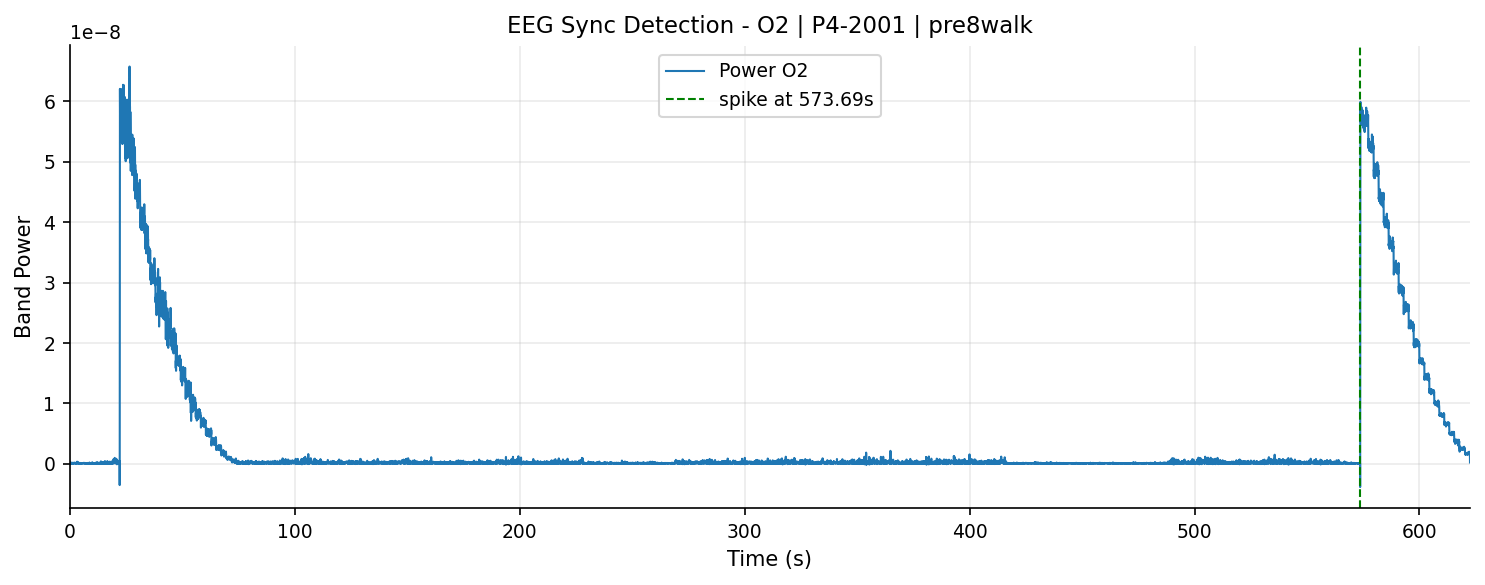

In [6]:
# full recording
_, _, _, _, _ = detect_eeg_sync_artifact(
    eeg_raw_pd,
    freq_low=120.0,
    freq_high=130.0,
    time_range=None,
    plot=True,
    save_dir=None,
    sub_id=sub_id,
    block=block
)

=== P4-2001 EEG Artifact Detection ===


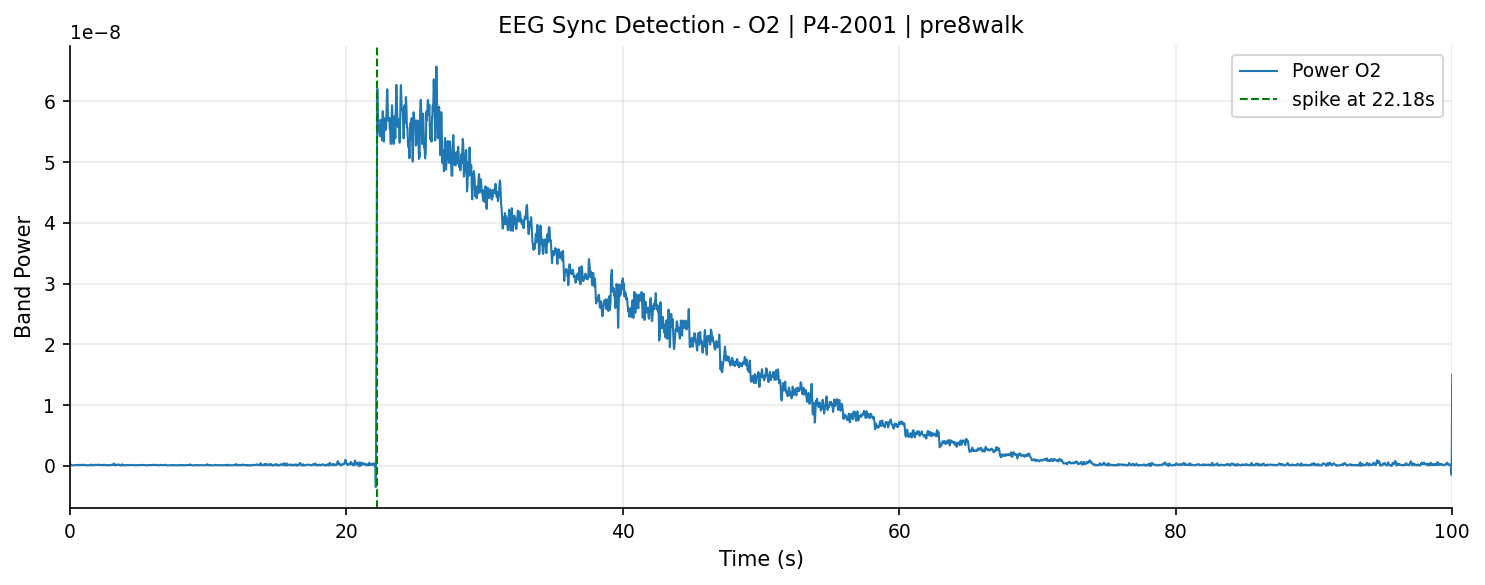

EEG sync artifact detected at: 22.183 sec (index: 44367, channel: O2)


In [7]:
# Detect first EEG sync artifact with plotting
print("=== P4-2001 EEG Artifact Detection ===")
channel_pd, eeg_sync_idx_pd, eeg_sync_s_pd, result_pd, smoothed_power_pd = detect_eeg_sync_artifact(
    eeg_raw_pd,
    freq_low=120.0,
    freq_high=130.0,
    time_range=[0,100],
    # time_range=None,
    plot=True,
    save_dir=None,
    sub_id=sub_id,
    block=block
)
print(f"EEG sync artifact detected at: {eeg_sync_s_pd:.3f} sec (index: {eeg_sync_idx_pd}, channel: {channel_pd})")


=== P4-2001 DBS Artifact Detection ===


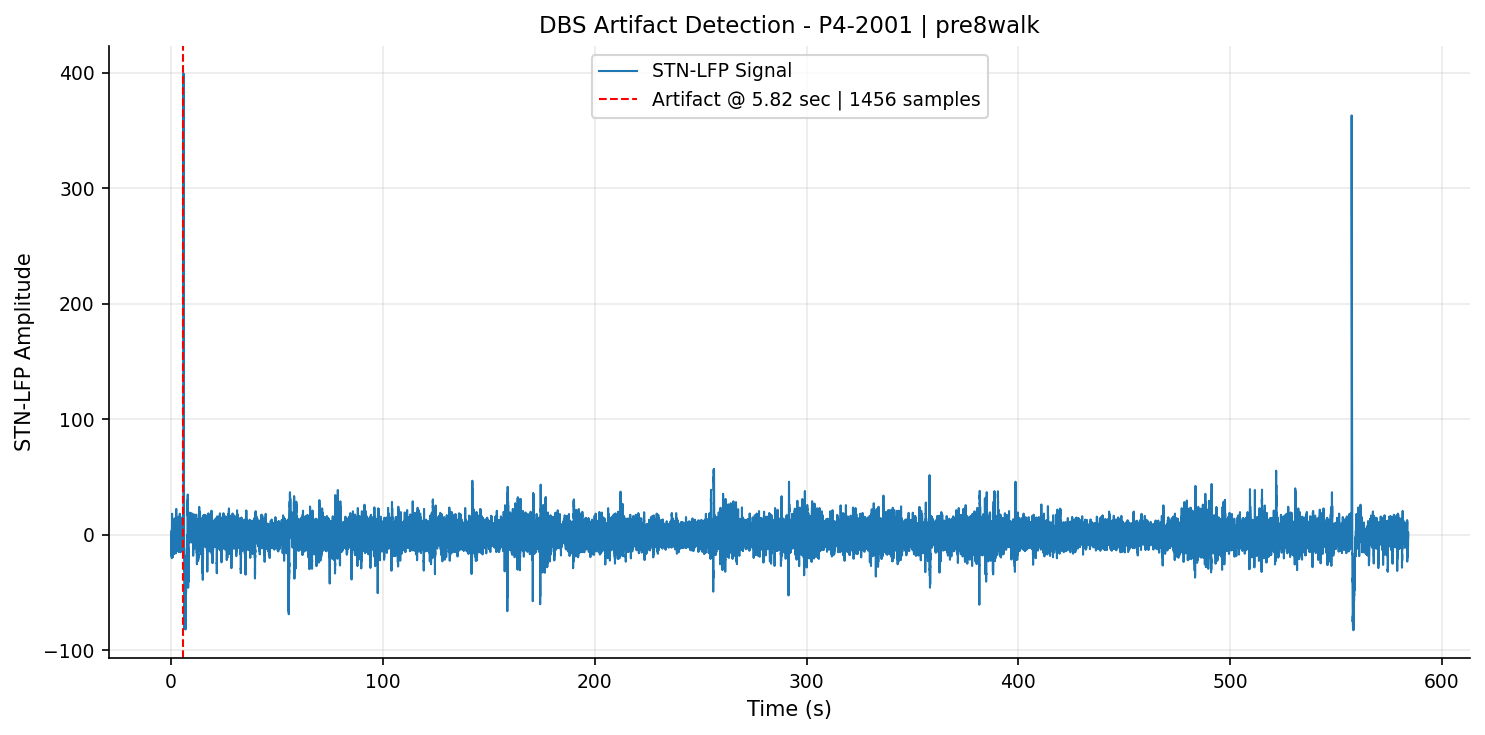

DBS sync artifact detected at: 5.824 sec (index: 1456)


In [8]:
# Detect DBS sync artifact with plotting
print("=== P4-2001 DBS Artifact Detection ===")
dbs_sync_idx_pd, dbs_sync_s_pd = detect_dbs_sync_artifact(
    dbs_signal_pd, 
    dbs_fs_pd, 
    plot=True, 
    save_dir=None,
    sub_id=sub_id,
    block=block
)
print(f"DBS sync artifact detected at: {dbs_sync_s_pd:.3f} sec (index: {dbs_sync_idx_pd})")


P4-2001: Artifact 2

=== P4-2001 EEG Artifact Detection ===


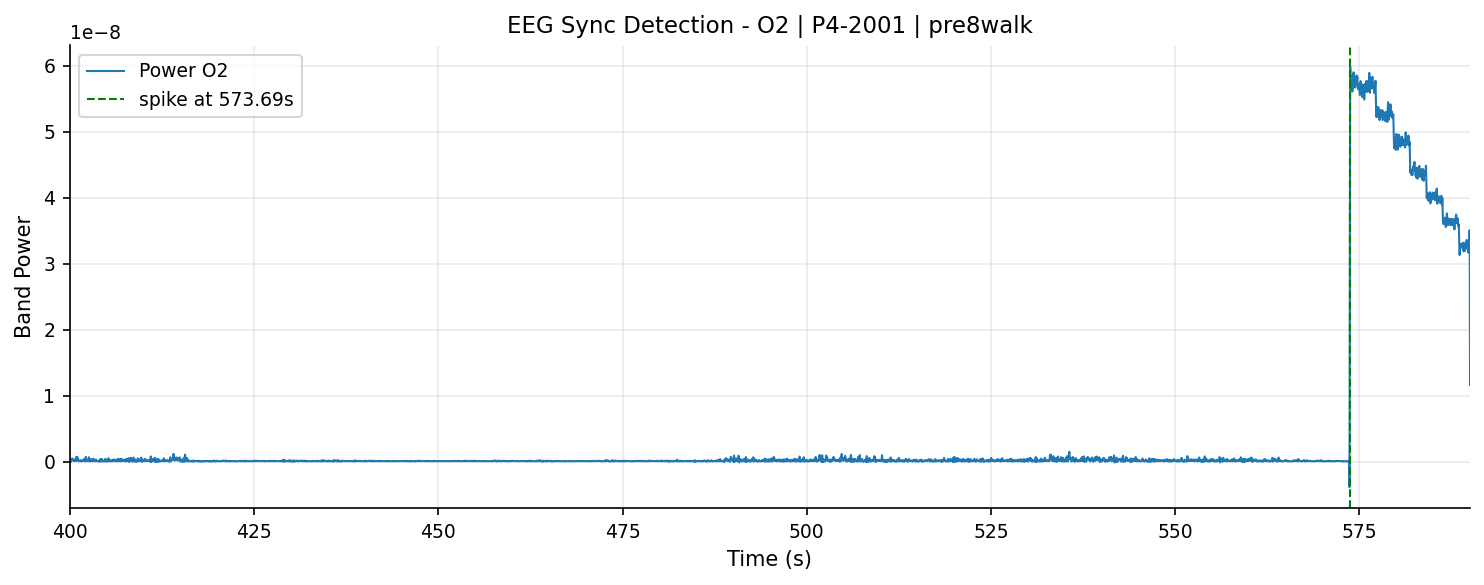

EEG sync artifact detected at: 573.689 sec (index: 1147379, channel: O2)
=== P4-2001 DBS Artifact Detection ===


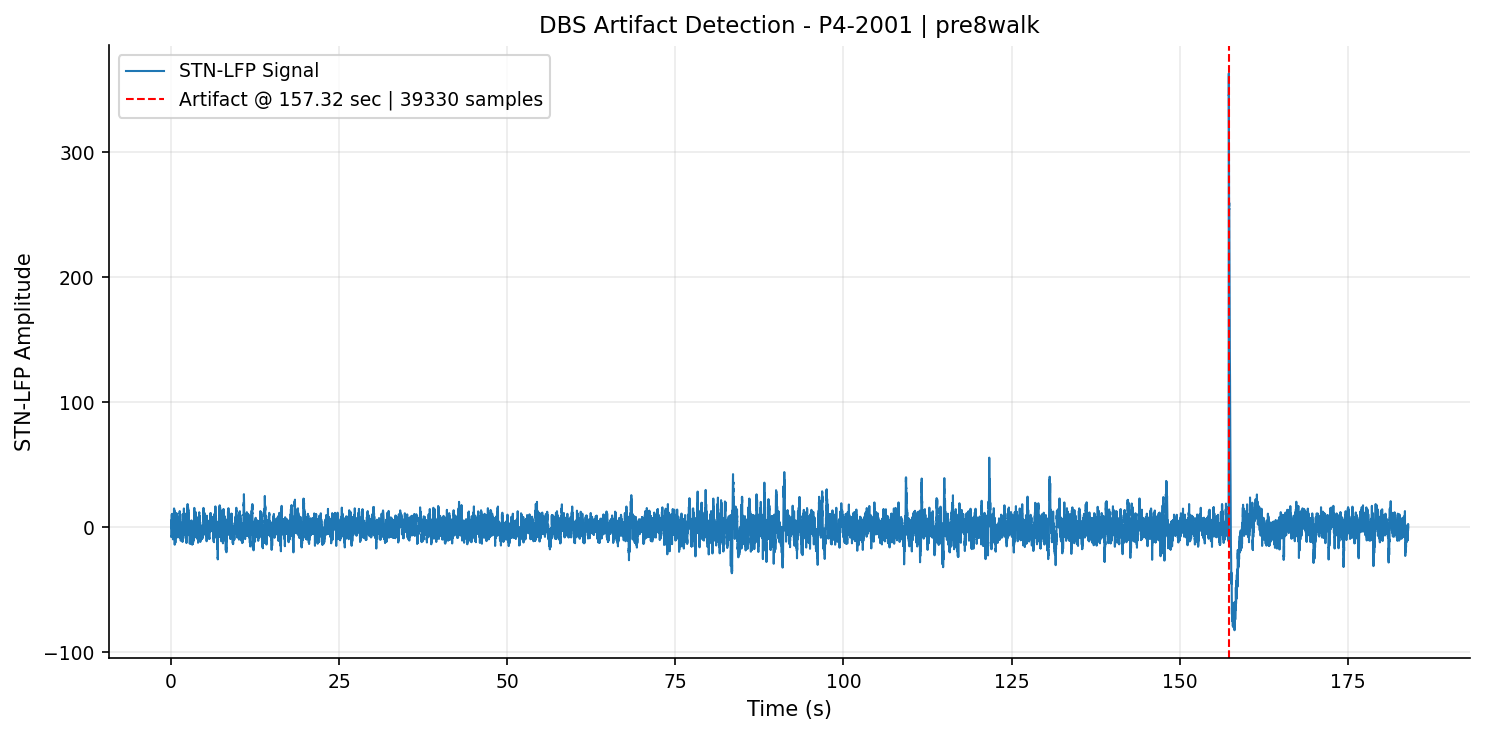

DBS sync artifact detected at: 557.320 sec (index: 139330)


In [9]:
# Detect EEG sync artifact with plotting
print("=== P4-2001 EEG Artifact Detection ===")
channel_pd, eeg_sync_idx2_pd, eeg_sync_s2_pd, result_pd, smoothed_power_pd = detect_eeg_sync_artifact(
    eeg_raw_pd,
    freq_low=120.0,
    freq_high=130.0,
    time_range=[400,590],
    plot=True,
    save_dir=None,
    sub_id=sub_id,
    block=block
)
print(f"EEG sync artifact detected at: {eeg_sync_s2_pd:.3f} sec (index: {eeg_sync_idx2_pd}, channel: {channel_pd})")


# Detect DBS sync artifact with plotting
print("=== P4-2001 DBS Artifact Detection ===")
# cut dbs_signal_pd to time_range
dbs_signal_pd_cut = dbs_signal_pd[400*dbs_fs_pd:590*dbs_fs_pd]
dbs_sync_idx2_pd, dbs_sync_s2_pd = detect_dbs_sync_artifact(
    dbs_signal_pd_cut, 
    dbs_fs_pd, 
    plot=True, 
    save_dir=None,
    sub_id=sub_id,
    block=block
)

# convert the index to the original index
dbs_sync_idx2_pd = dbs_sync_idx2_pd + 400*dbs_fs_pd
dbs_sync_s2_pd = dbs_sync_s2_pd + 400
print(f"DBS sync artifact detected at: {dbs_sync_s2_pd:.3f} sec (index: {dbs_sync_idx2_pd})")


### Epilepsy Patient 2: Artifact Detection


In [10]:
# # Detect EEG sync artifact with plotting
# print("=== Epilepsy Patient 2 EEG Artifact Detection ===")
# channel_epi, eeg_sync_idx_epi, eeg_sync_s_epi, result_epi, smoothed_power_epi = detect_eeg_sync_artifact(
#     eeg_raw_epi,
#     freq_low=120.0,
#     freq_high=130.0,
#     time_range=[0, 180],
#     plot=True,
#     save_dir=None,
#     sub_id="epi_pat2",
#     block="recording"
# )
# print(f"EEG sync artifact detected at: {eeg_sync_s_epi:.3f} sec (index: {eeg_sync_idx_epi}, channel: {channel_epi})")


In [11]:
# # Detect DBS sync artifact with plotting
# print("=== Epilepsy Patient 2 DBS Artifact Detection ===")
# dbs_sync_idx_epi, dbs_sync_s_epi = detect_dbs_sync_artifact(
#     dbs_signal_epi, 
#     dbs_fs_epi, 
#     plot=True, 
#     save_dir=None,
#     sub_id="epi_pat2",
#     block="recording"
# )
# print(f"DBS sync artifact detected at: {dbs_sync_s_epi:.3f} sec (index: {dbs_sync_idx_epi})")


## Align Signals at First Artifact

Using your existing `cut_data_at_sync()` and `synchronize_data()` functions.


In [12]:
# print the sampling rate of the eeg and dbs signals
print(f"EEG sampling rate: {eeg_raw_pd.info['sfreq']} Hz")
print(f"DBS sampling rate: {dbs_fs_pd} Hz")

# print the sync indices
print(f"EEG sync index 1: {eeg_sync_idx_pd}")
print(f"EEG sync index 2: {eeg_sync_idx2_pd}")
print(f"DBS sync index 1: {dbs_sync_idx_pd}")
print(f"DBS sync index 2: {dbs_sync_idx2_pd}")

# print the sync seconds
print(f"EEG sync seconds 1: {eeg_sync_s_pd}")
print(f"EEG sync seconds 2: {eeg_sync_s2_pd}")
print(f"DBS sync seconds 1: {dbs_sync_s_pd}")
print(f"DBS sync seconds 2: {dbs_sync_s2_pd}")



EEG sampling rate: 2000.0 Hz
DBS sampling rate: 250 Hz
EEG sync index 1: 44367
EEG sync index 2: 1147379
DBS sync index 1: 1456
DBS sync index 2: 139330
EEG sync seconds 1: 22.1835
EEG sync seconds 2: 573.6895
DBS sync seconds 1: 5.824
DBS sync seconds 2: 557.3199999999999


In [13]:
import importlib
import dbs_eeg_sync.synchronizer
importlib.reload(dbs_eeg_sync.synchronizer)
from dbs_eeg_sync.synchronizer import synchronize_data, cut_data_at_sync

In [14]:
# P4-2001: Align at first artifact using your existing functions
print("=== P4-2001: Aligning at first artifact ===")

# Cut data at first sync points
eeg_cropped_pd, dbs_cropped_pd = cut_data_at_sync(
    eeg_raw_pd,
    dbs_data_pd,
    dbs_sync_idx=dbs_sync_idx_pd,
    eeg_sync_idx=eeg_sync_idx_pd  
)

# Synchronize (resample to common rate)
eeg_synced_pd, dbs_synced_pd = synchronize_data(
    eeg_cropped_pd,
    dbs_cropped_pd,
    resample_data=True,
    save_dir=None,
    sub_id=sub_id,
    block=block
)

=== P4-2001: Aligning at first artifact ===


In [15]:
# recalculate the sync indeces 2 for the cropped data
eeg_sync_idx2_pd = eeg_sync_idx2_pd - eeg_sync_idx_pd
dbs_sync_idx2_pd = dbs_sync_idx2_pd - dbs_sync_idx_pd

In [16]:

# print the sampling rate of the resampled eeg and dbs
print(f"Resampled EEG sampling rate: {eeg_synced_pd.info['sfreq']} Hz")
print(f"Resampled DBS sampling rate: {dbs_synced_pd['SampleRateInHz'].iloc[0]} Hz")

# compute the resampled sync indices for eeg
eeg_sync_idx2_resampled_pd = (eeg_sync_idx2_pd/eeg_raw_pd.info['sfreq'])*eeg_synced_pd.info['sfreq']

# print the resampled sync indices, only for the second artifact as the first one is at index 0
print(f"EEG sync index 2 resampled: {eeg_sync_idx2_resampled_pd}")
print(f"EEG sync index 2 resampled: {eeg_sync_idx2_resampled_pd/eeg_synced_pd.info['sfreq']:.2f} sec")
print(f"DBS sync index 2 resampled: {dbs_sync_idx2_pd}")
print(f"DBS sync index 2 resampled: {dbs_sync_idx2_pd/dbs_fs_pd:.2f} sec")

Resampled EEG sampling rate: 250.0 Hz
Resampled DBS sampling rate: 250.0 Hz
EEG sync index 2 resampled: 137876.5
EEG sync index 2 resampled: 551.51 sec
DBS sync index 2 resampled: 137874
DBS sync index 2 resampled: 551.50 sec


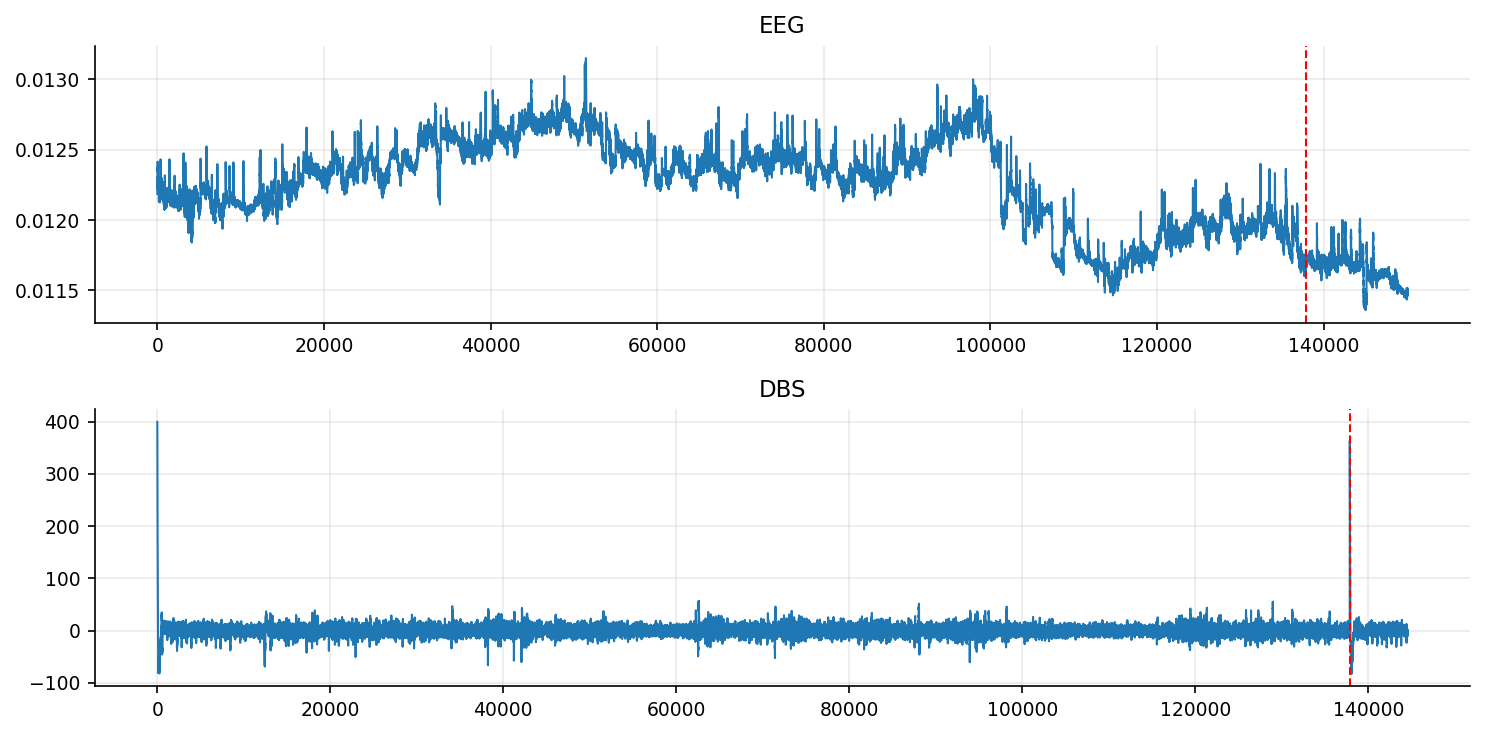

In [17]:
# plot the eeg and dbs signals with the sync indices
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
ax[0].plot(eeg_synced_pd.get_data()[0, :])
ax[0].axvline(eeg_sync_idx2_resampled_pd, color='red', linestyle='--')
ax[0].set_title('EEG')
ax[1].plot(dbs_synced_pd['TimeDomainData'].values)
ax[1].axvline(dbs_sync_idx2_pd, color='red', linestyle='--')
ax[1].set_title('DBS')
plt.show()

Artifact not visible in EEG raw signal!


freq_high (130.000) ≥ Nyquist (125.000); clamping to 124.000 Hz


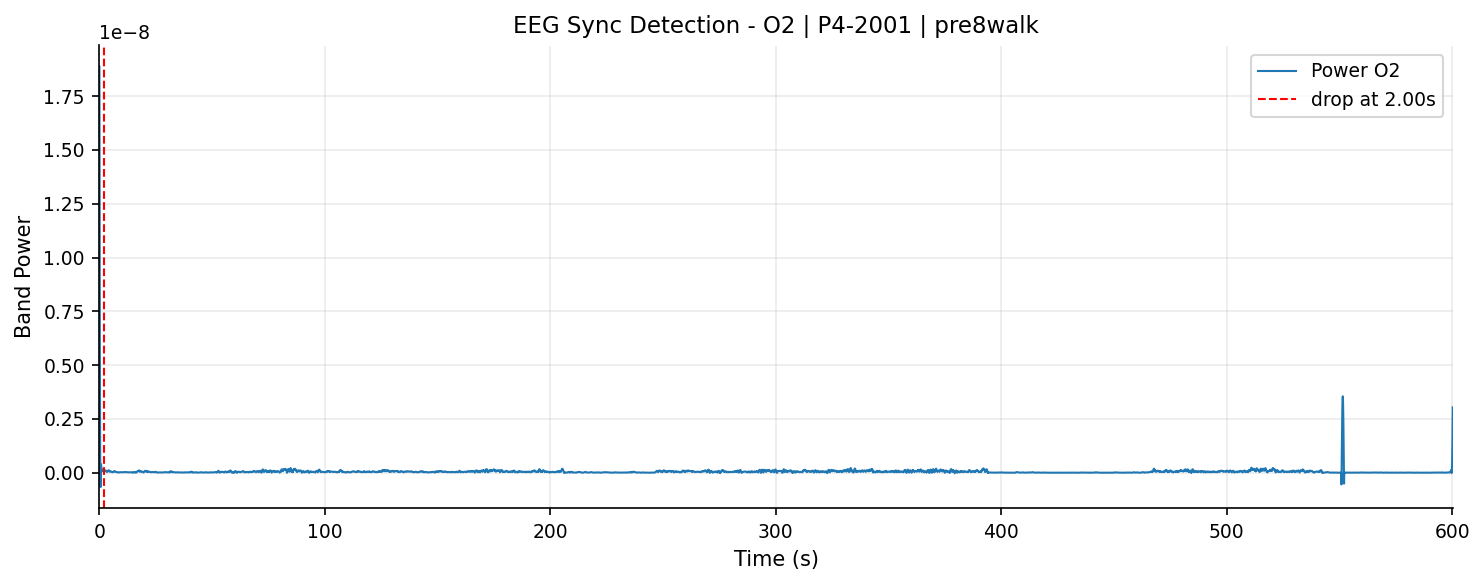

In [18]:
# compute power for the new eeg signal to show the artifact using the 

_, _, _, _, smoothed_power_pd_synced = detect_eeg_sync_artifact(
    eeg_synced_pd,
    freq_low=120.0,
    freq_high=130.0,
    time_range=None,
    # time_range=None,
    plot=True,
    save_dir=None,
    sub_id=sub_id,
    block=block
)

In [19]:
# Extract signals for plotting
dbs_fs_synced_pd = dbs_synced_pd['SampleRateInHz'].iloc[0]

# Get EEG data for the detected channel
ch_idx_pd = eeg_synced_pd.ch_names.index(channel_pd)
eeg_aligned_pd = eeg_synced_pd.get_data()[ch_idx_pd, :]
dbs_aligned_pd = dbs_synced_pd['TimeDomainData'].values

# Trim to same length (important!)
# Note: smoothed_power_pd_synced might be slightly different length due to edge effects
min_len_pd = min(len(eeg_aligned_pd), len(dbs_aligned_pd), len(smoothed_power_pd_synced))
eeg_aligned_pd = eeg_aligned_pd[:min_len_pd]
dbs_aligned_pd = dbs_aligned_pd[:min_len_pd]
smoothed_power_pd_synced = smoothed_power_pd_synced[:min_len_pd]

time_axis_pd = np.arange(min_len_pd) / dbs_fs_synced_pd
fs_pd = dbs_fs_synced_pd

print(f"Signals trimmed to common length: {min_len_pd} samples")

# Distance between artifacts
dbs_distance_pd = dbs_sync_idx2_pd - dbs_sync_idx_pd

print(f"Original EEG sampling rate: {eeg_raw_pd.info['sfreq']} Hz")
print(f"Original DBS sampling rate: {dbs_fs_pd} Hz")
print(f"Synchronized sampling rate: {fs_pd} Hz")
print(f"Aligned signal length: {min_len_pd} samples ({min_len_pd/fs_pd:.2f} sec)")
print(f"DBS artifact distance: {dbs_distance_pd} samples ({dbs_distance_pd/dbs_fs_pd:.2f} sec)")
print(f"Expected second artifact at index: {dbs_distance_pd}")


Signals trimmed to common length: 144544 samples
Original EEG sampling rate: 2000.0 Hz
Original DBS sampling rate: 250 Hz
Synchronized sampling rate: 250.0 Hz
Aligned signal length: 144544 samples (578.18 sec)
DBS artifact distance: 136418 samples (545.67 sec)
Expected second artifact at index: 136418


## Visualization

Create publication-quality figures showing both artifacts.


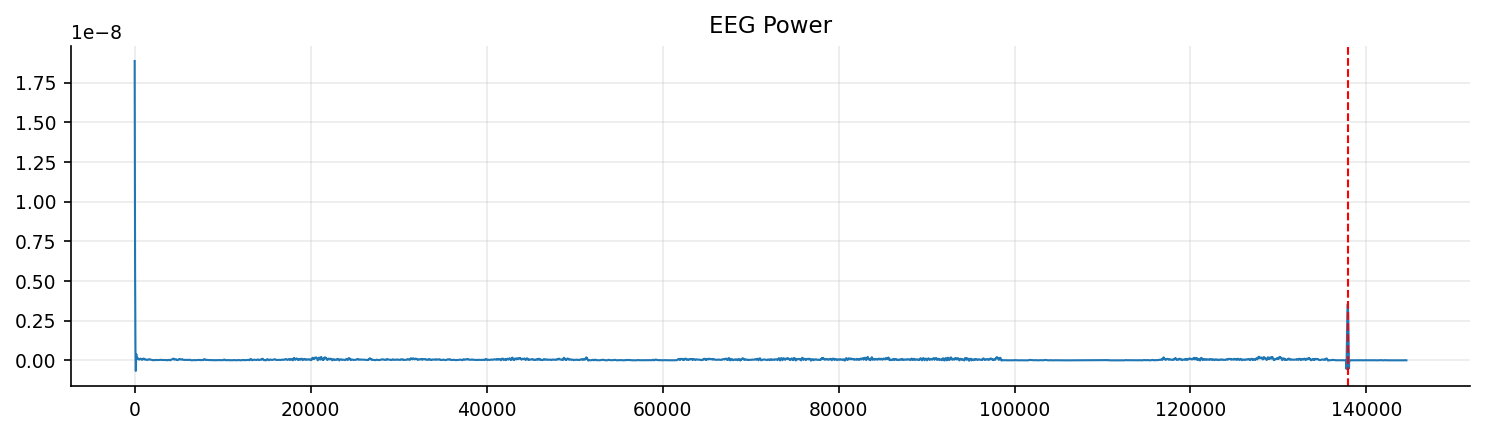

In [20]:
# plot the power of the resampled eeg signal with the sync indices
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(smoothed_power_pd_synced)
ax.axvline(eeg_sync_idx2_resampled_pd, color='red', linestyle='--')
ax.set_title('EEG Power')
plt.show()

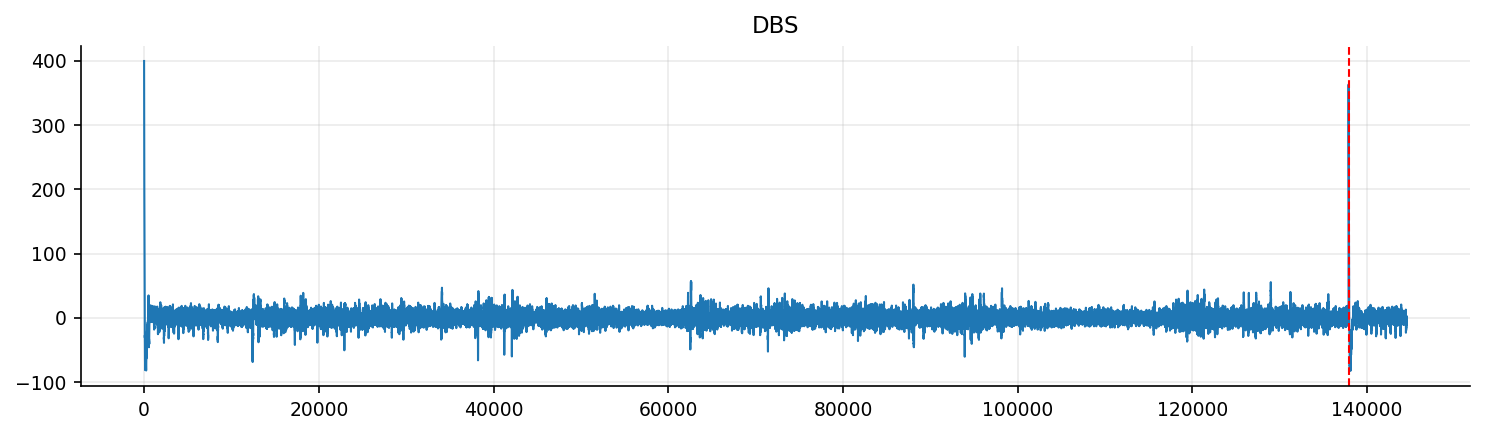

In [21]:
# plot the power of the resampled dbs signal with the sync indices
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(dbs_synced_pd['TimeDomainData'].values)
ax.axvline(dbs_sync_idx2_pd, color='red', linestyle='--')
ax.set_title('DBS')
plt.show()

In [69]:
def plot_artifacts_simple(eeg_power, dbs_signal, time_axis, fs, art1_idx, art2_idx, title):
    """Plot full recording + 2 artifact close-ups with dual y-axes."""
    apply_publication_style()
    
    fig = plt.figure(figsize=(14, 8))
    gs = fig.add_gridspec(2, 2, hspace=0.4, wspace=0.4)
    
    # 1. Full overview with dual y-axes
    ax1_left = fig.add_subplot(gs[0, :])
    eeg_line, = ax1_left.plot(time_axis, eeg_power, color=EEG_COLOR, linewidth=0.8, label='EEG Power')
    ax1_left.set_ylabel('EEG Power (μV²/Hz)', fontsize=18, color=EEG_COLOR)
    ax1_left.set_xlabel('Time (s)', fontsize=18)
    ax1_left.set_title(f'{title}', fontweight='bold', fontsize=18)
    ax1_left.tick_params(axis='x', labelsize=16)
    
    # Right y-axis for DBS
    ax1_right = ax1_left.twinx()
    dbs_line, = ax1_right.plot(time_axis, dbs_signal, color=DBS_COLOR, linewidth=0.8, label='DBS-LFP')
    ax1_right.set_ylabel('DBS-LFP (μV)', fontsize=18, color=DBS_COLOR)
    ax1_right.set_yticks([])
    
    # Artifact lines
    art1_line = ax1_left.axvline(time_axis[art1_idx], color='grey', linestyle='--', linewidth=3, alpha=0.7, label='Artifact 1')
    art2_line = ax1_left.axvline(time_axis[art2_idx], color='black', linestyle='--', linewidth=3, alpha=0.7, label='Artifact 2')
    
    # Remove spines
    for ax in [ax1_left, ax1_right]:
        for spine in ['top', 'right', 'left']:
            ax.spines[spine].set_visible(False)
    ax1_left.set_yticks([])
    ax1_left.grid(True, linestyle="--", alpha=0.3)
    
    # Legend
    lines = [eeg_line, dbs_line, art1_line, art2_line]
    labels = [line.get_label() for line in lines]
    # ax1_left.legend(lines, labels, fontsize=16, loc='upper right', frameon=False)
    # place lagend in the middle of the plot and put a box around it
    ax1_left.legend(lines, labels, fontsize=14, loc='upper right', frameon=True, bbox_to_anchor=(0.85, 1))
    ax1_left.text(0.02, 1.1, 'A', transform=ax1_left.transAxes, fontsize=18, fontweight='bold', va='top', ha='left')
    
    # 2. Artifact 1 close-up (3 second window) with dual y-axes
    window = int(3 * fs)
    start1 = max(0, art1_idx - window//2)
    end1 = min(len(time_axis), art1_idx + window//2)
    
    ax2_left = fig.add_subplot(gs[1, 0])
    eeg_line2, = ax2_left.plot(time_axis[start1:end1], eeg_power[start1:end1], color=EEG_COLOR, linewidth=1.2, label='EEG Power')
    ax2_left.set_ylabel('EEG Power (μV²/Hz)', fontsize=18, color=EEG_COLOR)
    ax2_left.set_xlabel('Time (s)', fontsize=18)
    ax2_left.set_title('Zoom: Alignment Point', fontweight='bold', fontsize=18)
    ax2_left.tick_params(axis='x', labelsize=16)
    
    # Right y-axis for DBS
    ax2_right = ax2_left.twinx()
    dbs_line2, = ax2_right.plot(time_axis[start1:end1], dbs_signal[start1:end1], color=DBS_COLOR, linewidth=1.2, label='DBS-LFP')
    ax2_right.set_ylabel('DBS-LFP (μV)', fontsize=18, color=DBS_COLOR)
    ax2_right.set_yticks([])
    
    art1_line2 = ax2_left.axvline(time_axis[art1_idx], color='grey', linestyle='--', linewidth=3, alpha=0.7, label='Artifact 1')
    
    # Remove spines
    for ax in [ax2_left, ax2_right]:
        for spine in ['top', 'right', 'left']:
            ax.spines[spine].set_visible(False)
    ax2_left.set_yticks([])
    ax2_left.grid(True, linestyle="--", alpha=0.3)
    
    # Legend
    # lines2 = [eeg_line2, dbs_line2, art1_line2]
    # labels2 = [line.get_label() for line in lines2]
    # ax2_left.legend(lines2, labels2, fontsize=16, loc='upper right', frameon=False)
    ax2_left.text(0.02, 1.1, 'B', transform=ax2_left.transAxes, fontsize=18, fontweight='bold', va='top', ha='left')
    
    # 3. Artifact 2 close-up (3 second window) with dual y-axes
    start2 = max(0, art2_idx - window//2)
    end2 = min(len(time_axis), art2_idx + window//2)
    
    ax3_left = fig.add_subplot(gs[1, 1])
    eeg_line3, = ax3_left.plot(time_axis[start2:end2], eeg_power[start2:end2], color=EEG_COLOR, linewidth=1.2, label='EEG Power')
    ax3_left.set_ylabel('EEG Power (μV²/Hz)', fontsize=18, color=EEG_COLOR)
    ax3_left.set_xlabel('Time (s)', fontsize=18)
    ax3_left.set_title('Zoom: Verification', fontweight='bold', fontsize=18)
    ax3_left.tick_params(axis='x', labelsize=16)
    
    # Right y-axis for DBS
    ax3_right = ax3_left.twinx()
    dbs_line3, = ax3_right.plot(time_axis[start2:end2], dbs_signal[start2:end2], color=DBS_COLOR, linewidth=1.2, label='DBS-LFP')
    ax3_right.set_ylabel('DBS-LFP (μV)', fontsize=18, color=DBS_COLOR)
    ax3_right.set_yticks([])
    
    art2_line3 = ax3_left.axvline(time_axis[art2_idx], color='black', linestyle='--', linewidth=3, alpha=0.9, label='Artifact 2')
    
    # Remove spines
    for ax in [ax3_left, ax3_right]:
        for spine in ['top', 'right', 'left']:
            ax.spines[spine].set_visible(False)
    ax3_left.set_yticks([])
    ax3_left.grid(True, linestyle="--", alpha=0.3)
    
    # Legend
    # lines3 = [eeg_line3, dbs_line3, art2_line3]
    # labels3 = [line.get_label() for line in lines3]
    # ax3_left.legend(lines3, labels3, fontsize=16, loc='upper right', frameon=False)
    ax3_left.text(0.02, 1.1, 'C', transform=ax3_left.transAxes, fontsize=18, fontweight='bold', va='top', ha='left')
    
    plt.tight_layout()
    return fig

print("Simplified plotting function defined")


Simplified plotting function defined


In [70]:
# Prepare indices for plotting (convert to int for array indexing)
artifact1_idx_plot = 0  # First artifact is at the alignment point (index 0)
artifact2_idx_plot = int(eeg_sync_idx2_resampled_pd)  # Your resampled index as integer

print(f"Using YOUR already-computed resampled indices for plotting:")
print(f"  Artifact 1: index {artifact1_idx_plot} (t=0s)")
print(f"  Artifact 2: index {artifact2_idx_plot} (t={artifact2_idx_plot/fs_pd:.2f}s)")

Using YOUR already-computed resampled indices for plotting:
  Artifact 1: index 0 (t=0s)
  Artifact 2: index 137876 (t=551.50s)


/var/folders/1_/cvx_3yt96s7gxzrkn4b55xlc0000gn/T/ipykernel_22343/2354066036.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


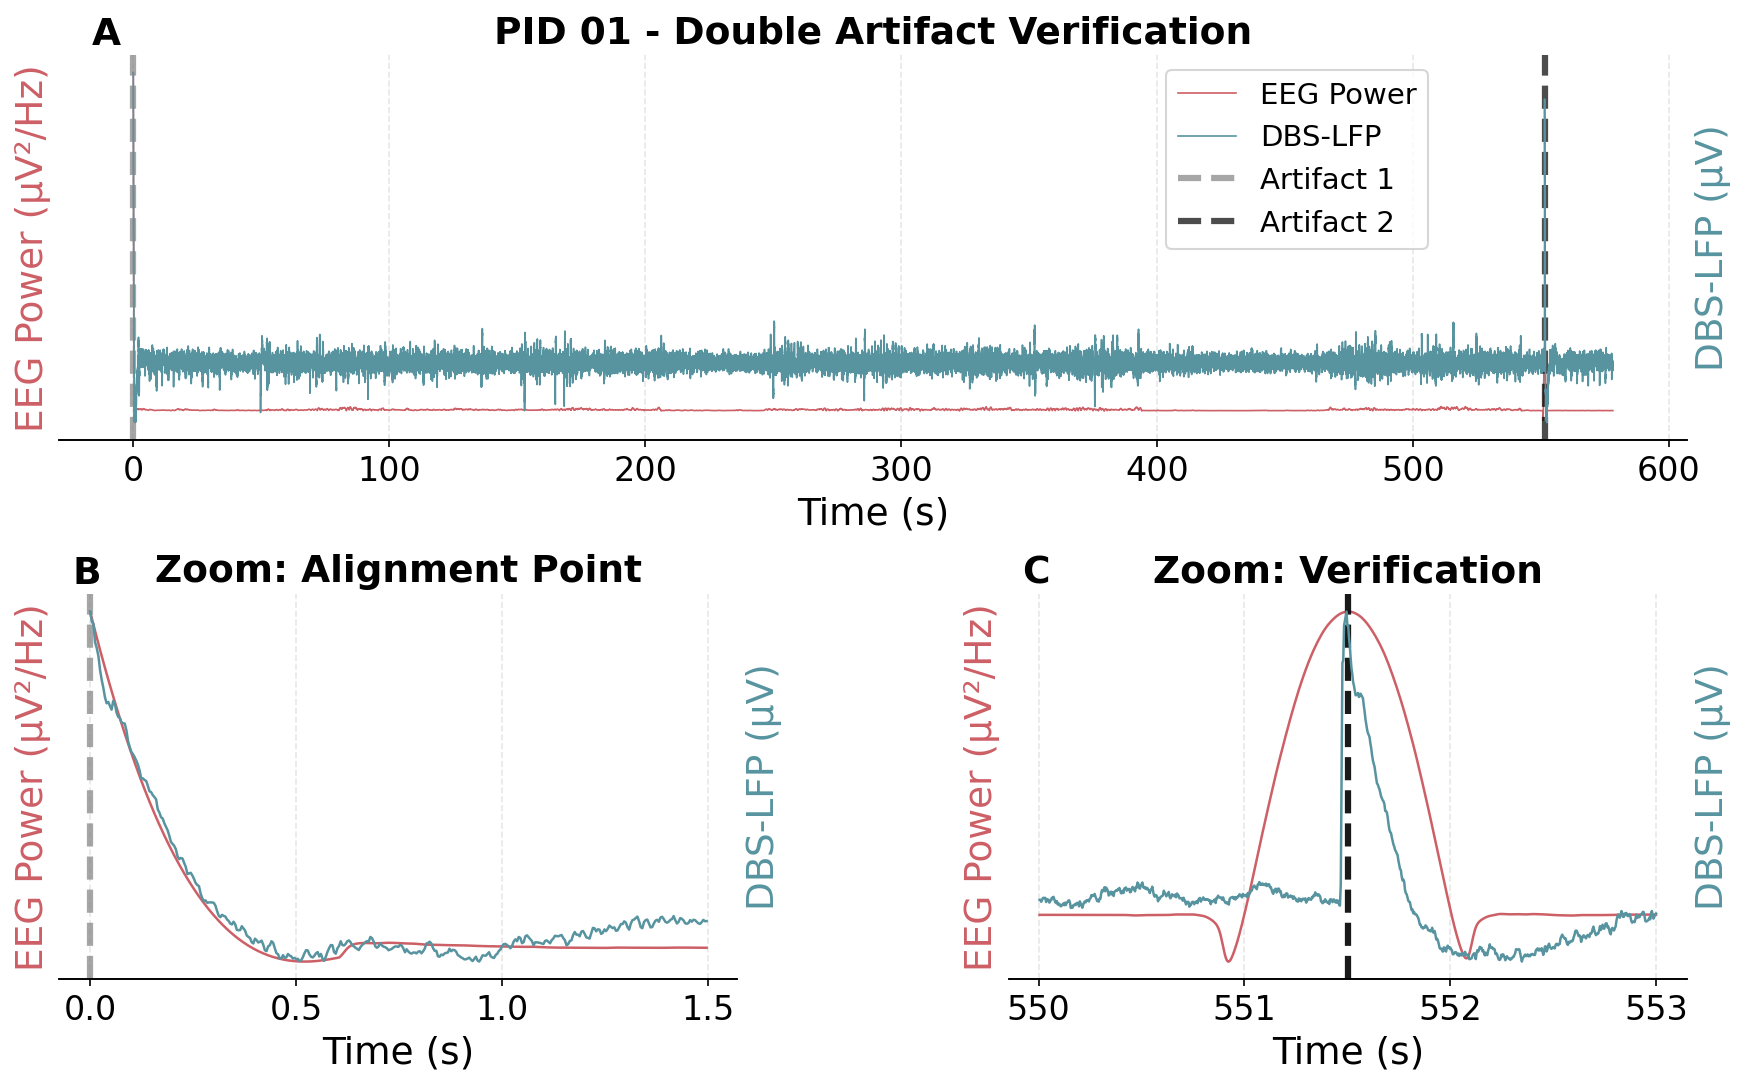

In [74]:
# Plot P4-2001 using the correctly calculated artifact positions
fig_pd = plot_artifacts_simple(
    smoothed_power_pd_synced, 
    dbs_aligned_pd, 
    time_axis_pd, 
    fs_pd,
    artifact1_idx_plot,  # 0 (alignment point) 
    artifact2_idx_plot,  # Calculated from YOUR detected indices
    "PID 01 - Double Artifact Verification"
)
# save as pdf to notebooks/outputs/plots/
fig_pd.savefig('outputs/plots/fig6_pd_double_artifact_verification.pdf', bbox_inches='tight')
plt.show()
